In [1]:
%load_ext jupyter_black

In [9]:
from typing import Dict, Any
from IPython.display import display
from graphviz import Digraph
import numpy as np
import pandas as pd


def entropy(y: np.ndarray) -> float:
    """Calculate the entropy of a target array."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / y.shape[0]
    return -np.sum(probs * np.log(probs + 1e-10))


def information_gain(X: np.ndarray, y: np.ndarray, feature_idx: int) -> float:
    """Calculate the information gain for a given feature."""
    parent_entropy = entropy(y)

    values, counts = np.unique(X[:, feature_idx], return_counts=True)
    probs = counts / y.shape[0]
    entropies = np.array(
        list(map(lambda x: entropy(y[X[:, feature_idx] == x]), values))
    )
    conditional_entropy = np.sum(probs * entropies)

    return parent_entropy - conditional_entropy


def select_best_feature(X: np.ndarray, y: np.ndarray, features: list) -> list:
    """Select the feature with the highest information gain."""
    best_idx = np.argmax([information_gain(X, y, i) for i in range(X.shape[1])])
    return [best_idx, features[best_idx]]


def id3_algorithm(X: np.ndarray, y: np.ndarray, features: list) -> Dict[str, Any]:
    """Recursively build the ID3 decision tree."""
    classes, counts = np.unique(y, return_counts=True)

    majority_class = classes[np.argmax(counts)]
    error = np.sum(y != majority_class)

    # Base case: all samples same class
    if len(classes) == 1 or not features:
        return {"class": classes[0], "majority_class": classes[0], "error": error}

    best_id, best_feature = select_best_feature(X, y, features)
    feature_values = np.unique(X[:, best_id])
    new_features = features.copy()
    new_features.remove(best_feature)

    tree = {
        "feature": best_feature,
        "majority_class": majority_class,
        "children": {},
        "error": error,
    }

    for value in feature_values:
        mask = X[:, best_id] == value
        X_sub, y_sub = np.delete(X, best_id, axis=1)[mask], y[mask]
        if len(y_sub) == 0:
            tree["children"][value] = {
                "majority_class": majority_class,
            }
        else:
            tree["children"][value] = id3_algorithm(X_sub, y_sub, new_features)

    return tree


def visualize_tree(
    tree: Dict[str, Any],
    feature_names: list,
    dot: Digraph = None,
    parent: str = None,
    edge_label: str = None,
) -> Digraph:
    """Recursively visualize the decision tree using Graphviz."""
    if dot is None:
        dot = Digraph(comment="Decision Tree")

    # Create a unique node ID
    node_id = str(id(tree))

    # Add the current node
    if not "children" in tree:
        node_label = f"Class: {tree['majority_class']}\nError: {tree['error']}"
    else:
        node_label = f"Feature: {tree['feature']}\nError: {tree['error']}"
    dot.node(node_id, node_label)

    # Connect to parent node if exists
    if parent is not None:
        dot.edge(parent, node_id, label=edge_label)

    # Recursively add children
    if "children" in tree:
        for value, child in tree["children"].items():
            visualize_tree(child, feature_names, dot, node_id, str(value))

    return dot


class DecisionTree:
    """
    Decision tree classifier, which can be trained, can predict class labels(miraculously) and display itself if used in a frontend environment.
    """

    def __init__(self):
        self._features = []
        self._tree = {}

    def fit(self, X: np.ndarray, y: np.ndarray, features: list) -> None:
        """Fit the decision tree to passed data."""
        self._features = features
        self._tree = id3_algorithm(X, y, features)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels for given data."""
        ans = np.zeros((X.shape[0],), dtype="object")
        for i in range(ans.shape[0]):
            node = self._tree
            while "children" in node:
                feature_id = self._features.index(node["feature"])
                node = node["children"][X[i, feature_id]]
            ans[i] = node["majority_class"]
        return ans

    def show_tree(self):
        """Visualize the decision tree."""
        dot = visualize_tree(self._tree, self._features)
        display(dot)

In [10]:
dataset = {
    "Taste": [
        "Salty",
        "Spicy",
        "Spicy",
        "Spicy",
        "Spicy",
        "Sweet",
        "Salty",
        "Sweet",
        "Spicy",
        "Salty",
    ],
    "Temperature": [
        "Hot",
        "Hot",
        "Hot",
        "Cold",
        "Hot",
        "Cold",
        "Cold",
        "Hot",
        "Cold",
        "Hot",
    ],
    "Texture": [
        "Soft",
        "Soft",
        "Hard",
        "Hard",
        "Hard",
        "Soft",
        "Soft",
        "Soft",
        "Soft",
        "Hard",
    ],
    "Eat": ["No", "No", "Yes", "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes"],
}
dataframe = pd.DataFrame(dataset, columns=["Taste", "Temperature", "Texture", "Eat"])

# Prepare features and target
feature_names = dataframe.columns[:-1].tolist()
x_train = dataframe[feature_names].to_numpy()
y_train = dataframe["Eat"].to_numpy()
classifier = DecisionTree()
classifier.fit(x_train, y_train, feature_names.copy())

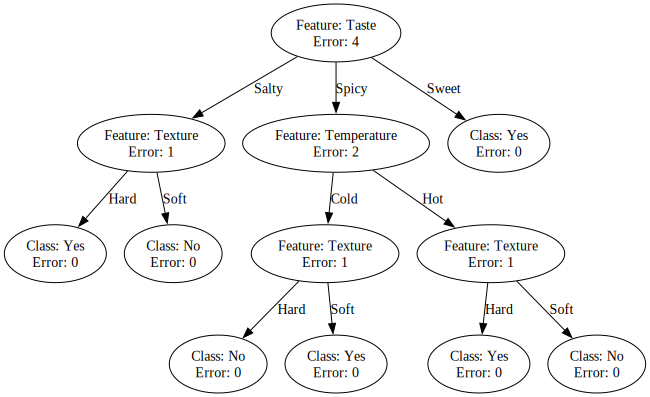

In [11]:
classifier.show_tree()

In [12]:
x_test = np.array([["Salty", "Hot", "Hard"]], dtype="object")
prediction = classifier.predict(x_test)
print(f"Prediction for the new data point(s): {prediction}")

Prediction for the new data point(s): ['Yes']


In [38]:
# implementation?

from copy import deepcopy


def compute_subtree_error(tree: Dict) -> int:
    """Calculate the total misclassification error of a subtree."""

    if not "children" in tree:
        return tree["error"]

    total_error = 0
    for child in tree["children"]:
        total_error += compute_subtree_error(tree["children"][child])

    return total_error


def compute_subtree_leaves(tree: Dict) -> int:
    """Count the number of leaf nodes in a subtree."""
    if not "children" in tree:
        return 1

    total_leaves = 0
    for child in tree["children"]:
        total_leaves += compute_subtree_leaves(tree["children"][child])

    return total_leaves


def collect_pruning_candidates(tree: Dict, candidates: list) -> None:
    """Collect non-leaf nodes with their effective alpha values."""
    if not "children" in tree:
        return candidates

    subtree_error = compute_subtree_error(tree)
    complexity_error = compute_subtree_leaves(tree)
    R = tree["error"]
    effective_alpha = (R - subtree_error) / complexity_error

    for child in tree["children"]:
        collect_pruning_candidates(tree["children"][child], candidates)

    candidates.append((tree, effective_alpha))

    return candidates


def cost_complexity_pruning(tree: Dict, alpha: float) -> Dict:
    """Prune the tree using cost-complexity pruning with parameter alpha."""
    tree_copy = deepcopy(tree)
    while True:
        candidates = []
        candidates = collect_pruning_candidates(tree_copy, candidates)
        candidates.sort(key=lambda x: x[1])

        if not candidates:
            break

        weakest_subtree, weakest_alpha = candidates[0]

        print(weakest_alpha)

        if weakest_alpha > alpha:
            break

        weakest_subtree["children"] = {}
        weakest_subtree.pop("feature")

    return tree

In [40]:
cands = collect_pruning_candidates(classifier._tree, [])
[c[1] for c in cands]

[0.5, 0.5, 0.5, 0.5, 0.5714285714285714]

0.5


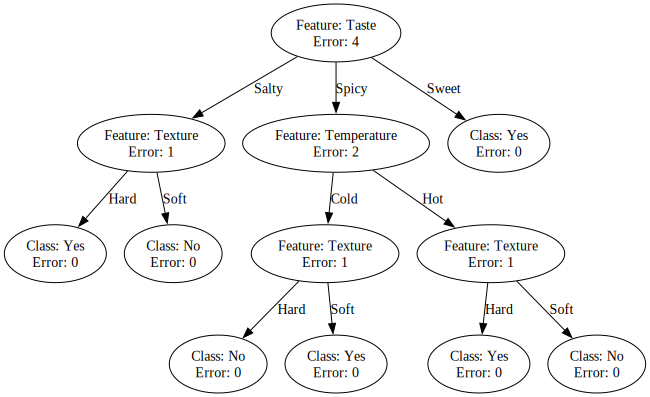

Prediction for the new data point(s): ['Yes']


In [39]:
# Prune the tree with alpha=0.1 (adjust alpha based on your needs)
alpha = 0.4
pruned_tree = cost_complexity_pruning(classifier._tree, alpha)

new_classifier = deepcopy(classifier)
new_classifier._tree = pruned_tree

# Visualize the pruned tree in Jupyter Notebook
dot_pruned = new_classifier.show_tree()

# Test prediction with the pruned tree
pruned_prediction = new_classifier.predict(x_test)
print(f"Prediction for the new data point(s): {pruned_prediction}")